In [18]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [55]:
def load_data_simulacao():
    data = pd.read_csv('arquivos/oasis_cross-sectional.csv')
    # Filtrar os dados onde MMSE e CDR não são nulos
    data = data.dropna(subset=['MMSE', 'CDR'])
    data.drop('Delay', axis=1, inplace=True)
    return data

data_simulacao = load_data_simulacao()

In [56]:
data_simulacao.info()

<class 'pandas.core.frame.DataFrame'>
Index: 235 entries, 0 to 415
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      235 non-null    object 
 1   M/F     235 non-null    object 
 2   Hand    235 non-null    object 
 3   Age     235 non-null    int64  
 4   Educ    235 non-null    float64
 5   SES     216 non-null    float64
 6   MMSE    235 non-null    float64
 7   CDR     235 non-null    float64
 8   eTIV    235 non-null    int64  
 9   nWBV    235 non-null    float64
 10  ASF     235 non-null    float64
dtypes: float64(6), int64(2), object(3)
memory usage: 22.0+ KB


In [59]:
data_simulacao_idades_cdr = data_simulacao[['Age', 'CDR']].copy()
data_simulacao_idades_cdr.dropna(inplace=True)
data_simulacao_idades_cdr.reset_index(drop=True, inplace=True)

In [60]:
data_simulacao_idades_cdr

,Age,CDR
0,74,0.0
1,55,0.0
2,73,0.5
3,74,0.0
4,52,0.0
...,...,...
230,70,0.5
231,73,0.5
232,61,0.0
233,61,0.0


In [61]:
# Filtrar apenas idades maiores ou iguais a 65
data_65_plus = data_simulacao_idades_cdr[data_simulacao_idades_cdr['Age'] >= 65].copy()

# Definir os intervalos e rótulos para as faixas etárias desejadas
bins = [65, 70, 75, 80, 85, 90, float('inf')]
labels = ['65-69', '70-74', '75-79', '80-84', '85-89', '90+']

# Criar a coluna de faixa etária
data_65_plus['faixa_etaria'] = pd.cut(data_65_plus['Age'], bins=bins, labels=labels, right=False)

# Agrupar por faixa etária e CDR
cdr_faixa_table = data_65_plus.groupby(['faixa_etaria', 'CDR'], observed=True).size().reset_index(name='Count')

# Pivotar a tabela para melhor visualização
cdr_faixa_table = cdr_faixa_table.pivot(index='faixa_etaria', columns='CDR', values='Count').fillna(0)

cdr_faixa_table

CDR,0.0,0.5,1.0,2.0
faixa_etaria,,,,
65-69,14.0,8.0,3.0,0.0
70-74,26.0,19.0,6.0,0.0
75-79,9.0,13.0,9.0,1.0
80-84,17.0,19.0,6.0,0.0
85-89,13.0,3.0,3.0,1.0
90+,8.0,4.0,1.0,0.0


In [62]:
# Filtrar apenas idades maiores ou iguais a 60 e CDR > 0
data_cdr_pos = data_idades_cdr[(data_idades_cdr['Age'] >= 60) & (data_idades_cdr['CDR'] > 0)].copy()

# Definir os novos intervalos e rótulos para as faixas etárias
bins = [60, 70, 80, 90, float('inf')]
labels = ['60-69', '70-79', '80-89', '90+']

# Criar a nova coluna de faixa etária
data_cdr_pos['faixa_etaria'] = pd.cut(data_cdr_pos['Age'], bins=bins, labels=labels, right=False)

# Agrupar por faixa etária e CDR e contar
cdr_faixa_count = data_cdr_pos.groupby(['faixa_etaria', 'CDR'], observed=True).size().reset_index(name='Count')

# Calcular o total por faixa etária para depois calcular a porcentagem
total_por_faixa = cdr_faixa_count.groupby('faixa_etaria', observed=True)['Count'].transform('sum')
cdr_faixa_count['Percent'] = (cdr_faixa_count['Count'] / total_por_faixa) * 100

# Pivotar a tabela para ter as porcentagens por faixa etária e CDR
cdr_faixa_percent_table = cdr_faixa_count.pivot(index='faixa_etaria', columns='CDR', values='Percent').fillna(0)

# Exibir a tabela final
cdr_faixa_percent_table


CDR,0.5,1.0,2.0
faixa_etaria,,,
60-69,80.000000,20.000,0.000000
70-79,66.666667,31.250,2.083333
80-89,68.750000,28.125,3.125000
90+,80.000000,20.000,0.000000


# incremento do alzheimer por faixa etaria com proporções atuais

In [65]:
# Carregar os dois arquivos CSV gerados anteriormente
populacao_df = pd.read_csv("arquivos/populacao_idosos_2024_2040.csv")
alzheimer_df = pd.read_csv("arquivos/alzheimer_por_faixa_etaria.csv")

# Converter o dataframe de população para formato long (ano como linha)
populacao_long = populacao_df.melt(id_vars="faixa_etaria", var_name="Ano", value_name="Populacao")

# Mesclar com os dados de Alzheimer (porcentagem) com base na faixa etária
populacao_long = populacao_long.merge(alzheimer_df, on="faixa_etaria")

# Calcular o número estimado de pessoas com Alzheimer
populacao_long["Alzheimer_Projecao"] = populacao_long["Populacao"] * (populacao_long["Alzheimer (%)"] / 100)

# Converter a coluna 'Ano' para inteiro
populacao_long["Ano"] = populacao_long["Ano"].astype(int)



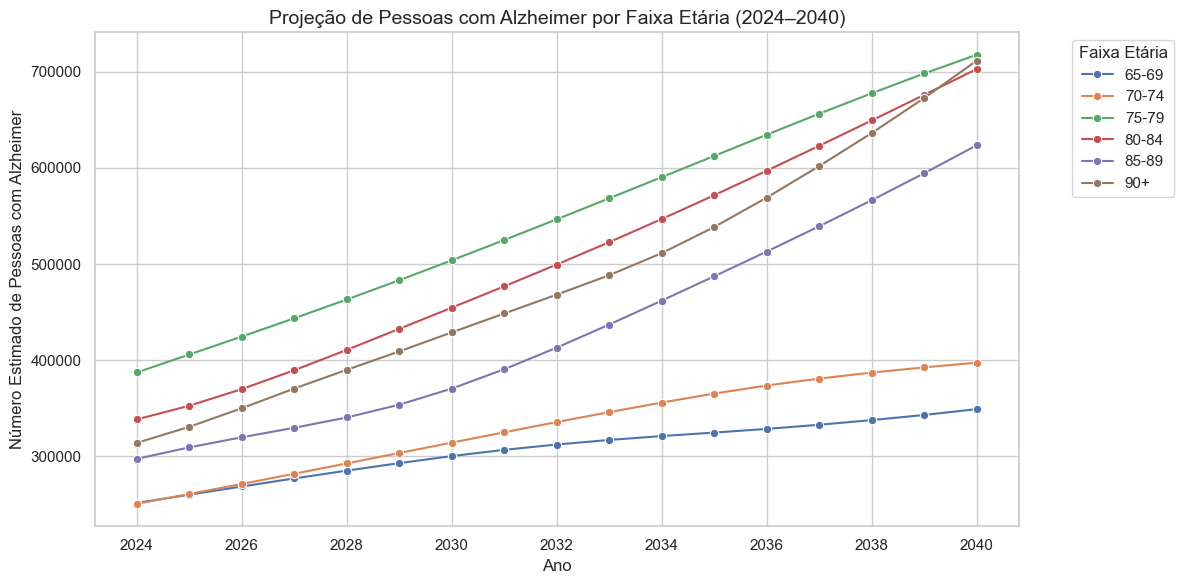

In [66]:


# Configurações de estilo
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

# Criar o gráfico de linha
sns.lineplot(data=populacao_long, x="Ano", y="Alzheimer_Projecao", hue="faixa_etaria", marker="o")

# Títulos e rótulos
plt.title("Projeção de Pessoas com Alzheimer por Faixa Etária (2024–2040)", fontsize=14)
plt.xlabel("Ano")
plt.ylabel("Número Estimado de Pessoas com Alzheimer")
plt.legend(title="Faixa Etária", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

In [67]:
alz_idade_ano = populacao_long[['Ano', 'faixa_etaria', 'Alzheimer_Projecao']].copy()

alz_idade_ano["faixa_etaria_ajustada"] = alz_idade_ano["faixa_etaria"].replace({
    "65-69": "60-69", "70-74": "70-79", "75-79": "70-79",
    "80-84": "80-89", "85-89": "80-89", "90+": "90+"
})

df_alzheimer = alz_idade_ano.copy()
df_tipo_alzheimer = cdr_faixa_percent_table.copy()


In [68]:
df_tipo_alzheimer

CDR,0.5,1.0,2.0
faixa_etaria,,,
60-69,80.000000,20.000,0.000000
70-79,66.666667,31.250,2.083333
80-89,68.750000,28.125,3.125000
90+,80.000000,20.000,0.000000


In [69]:
df_alzheimer

,Ano,faixa_etaria,Alzheimer_Projecao,faixa_etaria_ajustada
0,2024,65-69,251678.10,60-69
1,2024,70-74,250780.68,70-79
2,2024,75-79,387323.01,70-79
3,2024,80-84,338510.90,80-89
4,2024,85-89,297517.92,80-89
...,...,...,...,...
97,2040,70-74,397472.68,70-79
98,2040,75-79,717480.00,70-79
99,2040,80-84,702590.72,80-89
100,2040,85-89,623392.35,80-89


In [70]:
df_final = df_alzheimer.merge(df_tipo_alzheimer, left_on="faixa_etaria_ajustada", right_on="faixa_etaria", how="left")
df_final

,Ano,faixa_etaria,Alzheimer_Projecao,faixa_etaria_ajustada,0.5,1.0,2.0
0,2024,65-69,251678.10,60-69,80.000000,20.000,0.000000
1,2024,70-74,250780.68,70-79,66.666667,31.250,2.083333
2,2024,75-79,387323.01,70-79,66.666667,31.250,2.083333
3,2024,80-84,338510.90,80-89,68.750000,28.125,3.125000
4,2024,85-89,297517.92,80-89,68.750000,28.125,3.125000
...,...,...,...,...,...,...,...
97,2040,70-74,397472.68,70-79,66.666667,31.250,2.083333
98,2040,75-79,717480.00,70-79,66.666667,31.250,2.083333
99,2040,80-84,702590.72,80-89,68.750000,28.125,3.125000
100,2040,85-89,623392.35,80-89,68.750000,28.125,3.125000


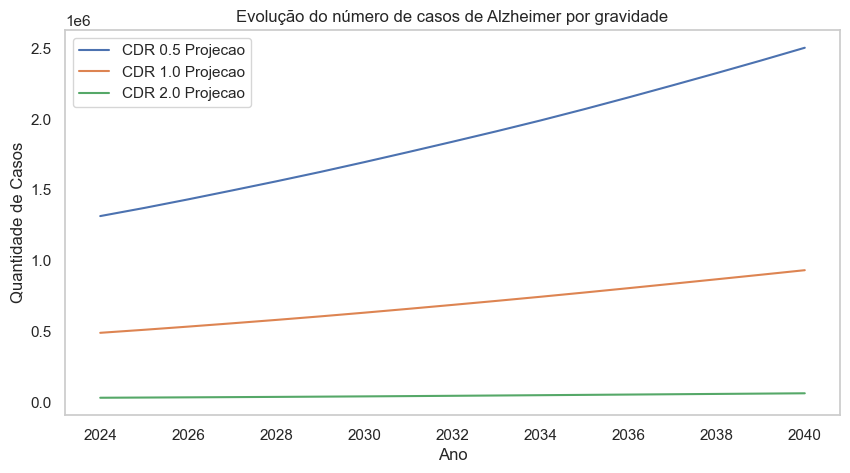

In [73]:

df_final["CDR 0.5 Projecao"] = (df_final["Alzheimer_Projecao"] * (df_final[0.5] / 100)).round(0)
df_final["CDR 0.5 Projecao"] = df_final["CDR 0.5 Projecao"].astype(int)
df_final["CDR 1.0 Projecao"] = (df_final["Alzheimer_Projecao"] * (df_final[1.0] / 100)).round(0)
df_final["CDR 1.0 Projecao"] = df_final["CDR 1.0 Projecao"].astype(int)
df_final["CDR 2.0 Projecao"] = (df_final["Alzheimer_Projecao"] * (df_final[2.0] / 100)).round(0)
df_final["CDR 2.0 Projecao"] = df_final["CDR 2.0 Projecao"].astype(int)

# Agrupar por ano
df_agrupado = df_final.groupby("Ano")[["CDR 0.5 Projecao", "CDR 1.0 Projecao", "CDR 2.0 Projecao"]].sum()

# Criar o gráfico
plt.figure(figsize=(10, 5))
for col in ["CDR 0.5 Projecao", "CDR 1.0 Projecao", "CDR 2.0 Projecao"]:
    plt.plot(df_agrupado.index, df_agrupado[col], label=col)

plt.xlabel("Ano")
plt.ylabel("Quantidade de Casos")
plt.title("Evolução do número de casos de Alzheimer por gravidade")
plt.legend()
plt.grid()
plt.show()


In [54]:
df_agrupado

,CDR 0.5 Projecao,CDR 1.0 Projecao,CDR 2.0 Projecao
Ano,,,
2024,1315315,491451,33169
2025,1372712,512867,34588
2026,1433506,535348,36062
2027,1496570,558656,37600
2028,1560714,582588,39226
2029,1626993,607502,40967
2030,1696258,633642,42834
2031,1767465,660718,44818
2032,1840048,688487,46898
